### SuperResolution GAN

We will be using imagenet (transfer learning for super resolution GAN creation)

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

import warnings
warnings.filterwarnings('ignore')

#### Data

In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [0]:
il = ImageImageList.from_folder(path_hr)

In [0]:
# shrink size of the images
def resize_one(fn,i, size, path):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [0]:
# parallel is a function in fastai for parallel execution of the function
parallel(resize_one, il.items, 96, path_lr)

In [0]:
# create 256 size medium quality images and save them to path_mr folder
parallel(resize_one, il.items, 256, path_mr)

In [6]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/small-96'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    return data

In [0]:
data = get_data(bs,size)

In [10]:
data

ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/small-96;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/small-96;

Test: None

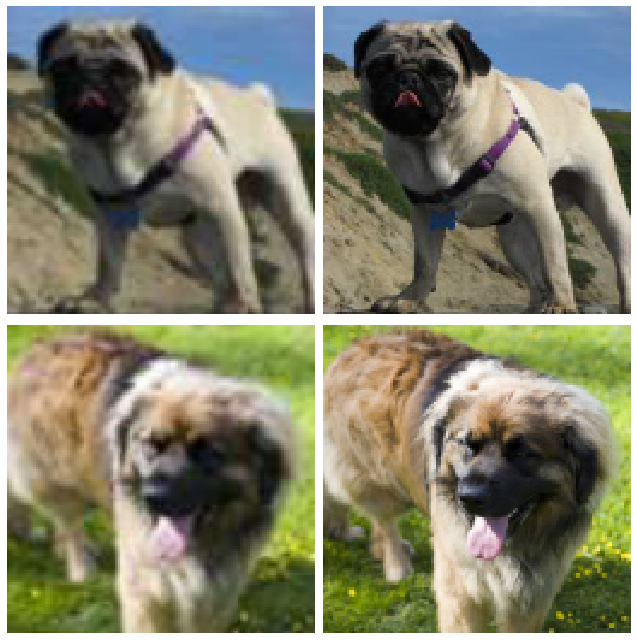

In [12]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

#### Feature loss

For SuperResolution GAN creation we use two types of losses

* Base Loss (L1 loss/ MSE)
* Feature Loss 

Feature loss is proposed in the paper [Perceptual Losses for Real-Time Style Transfer
and Super-Resolution](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf)



In [0]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [0]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [15]:
gram_matrix(t)

tensor([[[0.0812, 0.0811, 0.0763],
         [0.0811, 0.0826, 0.0799],
         [0.0763, 0.0799, 0.0809]],

        [[0.0812, 0.0811, 0.0763],
         [0.0811, 0.0826, 0.0799],
         [0.0763, 0.0799, 0.0809]]])

In [0]:
# L1 loss is base loss
base_loss = F.l1_loss

In [17]:
# loading vgg16 model to GPU
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:08<00:00, 61.7MB/s]


In [18]:
# Identifying the layers where MaxPooling is being done
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

![Feature Loss](https://miro.medium.com/max/1710/1*TdkNFoecrvBZZbLOHGse0Q.png)

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2]) # featured model = vgg_m, layer_ids = sending last three layers in blocks

#### Train

In [22]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight)
gc.collect();

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 52.5MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


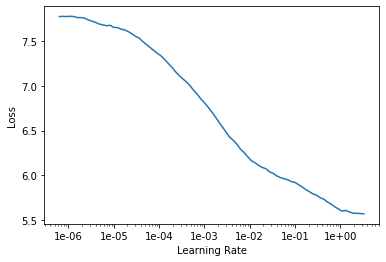

In [23]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-3

In [0]:
# function to fit, save and show_results
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(5, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.852178,3.676061,0.142121,0.228505,0.314746,0.222369,0.544079,1.192824,1.031417,04:03
1,3.815947,3.670344,0.150488,0.228117,0.312818,0.220888,0.543485,1.191232,1.023316,03:57
2,3.760326,3.561423,0.141595,0.224914,0.306297,0.215415,0.519565,1.152485,1.001153,03:55
3,3.731466,3.562744,0.145438,0.224456,0.304838,0.214405,0.521635,1.153568,0.998404,03:54
4,3.620232,3.416235,0.137086,0.223552,0.298358,0.206244,0.486396,1.106841,0.957759,03:54


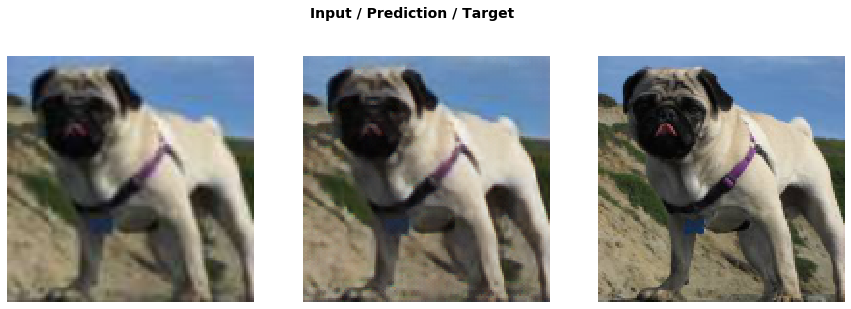

In [26]:
do_fit('1a', slice(lr*10))

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.577273,3.395384,0.136987,0.222798,0.296917,0.204875,0.482938,1.098855,0.952012,04:05
1,3.556097,3.381228,0.136871,0.222432,0.295946,0.203953,0.479454,1.094705,0.947869,04:05
2,3.552171,3.363703,0.137693,0.221837,0.294969,0.203159,0.473597,1.087232,0.945217,04:05
3,3.536326,3.338738,0.138359,0.221222,0.293824,0.201503,0.467138,1.079569,0.937124,04:05
4,3.517355,3.312646,0.137613,0.220896,0.291795,0.199469,0.462654,1.071967,0.928252,04:06


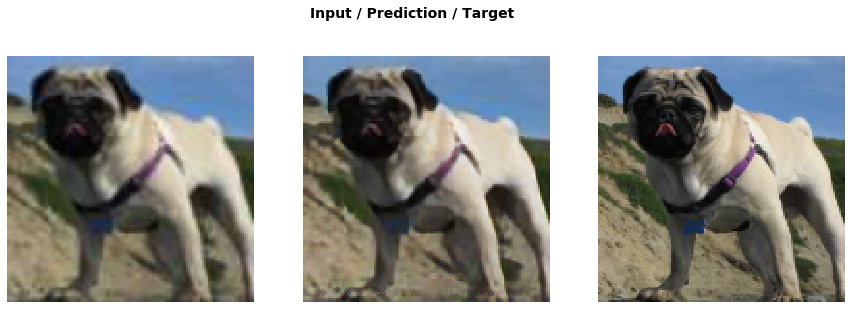

In [28]:
do_fit('1b', slice(1e-5,lr))

In [0]:
# increase size and half the batch size for the GPU to store data
data = get_data(12,size*2)

In [0]:
learn.data = data
learn.freeze()
gc.collect();

In [0]:
learn.load('1b');

In [0]:
do_fit('2a')

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.328174,2.315612,0.165076,0.265542,0.306817,0.166721,0.410919,0.603694,0.396843,17:09
1,2.285706,2.290011,0.167214,0.266613,0.305419,0.165592,0.397279,0.595652,0.392242,16:33
2,2.260036,2.271545,0.168660,0.266954,0.303882,0.164968,0.387183,0.591512,0.388387,16:33


In [0]:
learn.unfreeze()

In [0]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

#### Test

In [0]:
# set not using object to None and object wll be removed from memory
learn = None
gc.collect();

In [0]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [0]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=(1280,1600), tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [0]:
learn.load('2b');

In [0]:
learn.data = data_mr

In [0]:
fn = data_mr.valid_ds.x.items[0]; fn

In [0]:
img = open_image(fn); img.shape

In [0]:
p,img_hr,b = learn.predict(img)

In [0]:
show_image(img, figsize=(18,15), interpolation='nearest');

In [0]:
Image(img_hr).show(figsize=(18,15))